In [1]:
import healpy as hp
import numpy as np
import os
from os import listdir
import matplotlib.pyplot as plt
import h5py
import numpy.ma as ma
from scipy import signal, stats
import sys
from astropy.io import fits
import astropy.units as u
import pickle
from scipy.optimize import curve_fit

In [2]:
%matplotlib inline

In [3]:
def round_fraction(number, res):
    amount = int(number/res)*res
    remainder = number - amount
    return amount if remainder < res/2. else amount+res


In [4]:
def plotnow_azelsig(data, az, el, chan, var, res, minmax=None, radec=False, supply_index=False, return_map=False):
    # flp=select_h5(fpath,yrmoday,st_hour,st_minute,ed_hour,ed_minute)
    # fld_demod, fld =select_dat(fpath,yrmoday,st_hour,st_minute,ed_hour,ed_minute)
    # i=0
    # while len(flp)<3:
    #	i+=1
    #	flp=select_h5(fpath,yrmoday,st_hour,int(st_minute)-i,ed_hour,int(ed_minute)+i)

    # pp=get_h5_pointing(flp)
    ##dd=get_demodulated_data_from_list(fld,supply_index=supply_index)
    # dd=get_all_demodulated_data(fld_demod, fld)
    # combined=combine_cofe_h5_pointing(dd,pp)

    # synchronized data az and el values
    az1, el1 = az * 1, el * 1
    print(el1)
    data = data * 1

    # convert to temp for cryo sensors
    if chan == 12:
        data = convert.convert(data, 'i')
    if chan == 13:
        data = convert.convert(data, 'e')
    if chan == 14:
        data = convert.convert(data, 'h')
    if chan == 15:
        data = convert.convert(data, 'l')

    steps = len(data)

    # set az/el resolution
    dx = res
    dy = res

    # set up bins/grid
    if radec:
        x, y = np.arange(0., 360. + dx, dx), np.arange(-90., 90. + dy, dy)
    else:
        x, y = np.arange(0., 360. + dx, dx), np.arange(0., 90. + dy, dy)
    AZ, EL = np.meshgrid(x, y)

    # small number for comparing floats
    epsilon = 1e-6

    # set up matrix for signal
    z1 = np.zeros(len(x) * len(y))
    sig = np.reshape(z1, (len(y), len(x)))

    # set up matrix for keeping track of data points in single bin for averaging
    z2 = np.zeros(len(x) * len(y))
    count = np.reshape(z2, (len(y), len(x)))

    for i in range(steps):
        # round az/el points for comparison with grid
        el1[i] = round_fraction(el1[i], dy)
        az1[i] = round_fraction(az1[i], dx)

        # find where data points belong in grid
        iel = np.where(abs(y - el1[i]) < epsilon)[0][0]
        iaz = np.where(abs(x - az1[i]) < epsilon)[0][0]

        # add 1 each time data point lands in same bin
        count[iel][iaz] += 1

        # add total number of data values in bin
        sig[iel][iaz] = sig[iel][iaz] + data[i]

        # mask 0 count values so they dont show up in color plot
    count = ma.masked_where(count == 0.0, count)

    # take average of all data points in single bin
    sig = sig / count

    try:
        # change units on plot label
        if int(chan[2:]) < 12:
            unit = 'V'
        else:
            unit = 'K'

        name = rt.chantoname(chan)
    except:
        unit = 'C'
        name = chan

    if return_map:
        return AZ, EL, sig
    else:
        plt.pcolormesh(AZ, EL, sig, cmap='jet')
        plt.colorbar(label='Signal, %s' % unit)
        if minmax != None:
            plt.clim(minmax[0], minmax[1])
        else:
            plt.clim(data.min(), data.max())
        if radec == False:
            plt.axis([AZ.min(), AZ.max(), EL.min(), EL.max()])
            plt.ylabel('elevation (deg)')
            plt.xlabel('azimuth (deg)')
        else:
            plt.axis([0., 360., -90, 90.])
            plt.xlabel('ra (deg)')
            plt.ylabel('dec (deg)')
        plt.title('%s %s data binned to azimuth and elevation' % (name, var))
        plt.grid()
        plt.show()

In [5]:
def change_coord(m, coord):
    """ Change coordinates of a HEALPIX map

    Parameters
    ----------
    m : map or array of maps
      map(s) to be rotated
    coord : sequence of two character
      First character is the coordinate system of m, second character
      is the coordinate system of the output map. As in HEALPIX, allowed
      coordinate systems are 'G' (galactic), 'E' (ecliptic) or 'C' (equatorial)

    """
    # Basic HEALPix parameters    
    npix = len(m)
        
    nside = hp.npix2nside(npix)
    ang = hp.pix2ang(nside, np.arange(npix))

    # Select the coordinate transformation
    rot = hp.Rotator(coord=reversed(coord))

    # Convert the coordinates
    new_ang = rot(*ang)
    new_pix = hp.ang2pix(nside, *new_ang)

    return m[new_pix]

In [6]:
import os
os. getcwd()

'/Users/arikaplan/Documents/software_git_repos/polaris/polaris_software/notebook'

In [7]:
#this is pointing to c drive, move destriped data there!
day = '28+30'
periods = 'night'
#folder = 'dst_out_H3AC_night_only_removed_rev_offsets_10%s2020_out_256' % day
folder = 'dst_out_1028+1030_night_only_lines_removed_out_256'
#folder = 'dst_out_H3AC_night_only_uncleaned_out_256'
hitfile = '/Users/arikaplan/Documents/software_git_repos/polaris/polaris_data/destriped/move/%s/hits.fits' % folder
mapfile = '/Users/arikaplan/Documents/software_git_repos/polaris/polaris_data/destriped/move/%s/destriped.fits' % folder
baselinefile = '/Users/arikaplan/Documents/software_git_repos/polaris/polaris_data/destriped/move/%s/baselines.fits' % folder

In [8]:
NET = 1.11e-3 #* np.pi/2
TNET = 5e-3
sampling_frequency = 33.97
gain = 1.21
gerror = 0.25
nside = 256

In [9]:
.4*2*5/1.11/np.pi
2.04*5/1.11
0.16*2*5/1.11/np.pi

0.4588250611658244

In [10]:
hits = hp.read_map(hitfile)
hits[hits == 0.0] = hp.UNSEEN
T = hp.read_map(mapfile, field=0)
Q = hp.read_map(mapfile, field=1)
U = hp.read_map(mapfile, field=2)

baselineT = hp.read_map(baselinefile, field=0)
baselineQ = hp.read_map(baselinefile, field=1)
baselineU = hp.read_map(baselinefile, field=2)

#T[hits!=hp.UNSEEN] = T[hits!=hp.UNSEEN]*1e3
#Q[hits!=hp.UNSEEN] = Q[hits!=hp.UNSEEN]*1e3
#U[hits!=hp.UNSEEN] = U[hits!=hp.UNSEEN]*1e3

##binT[hits!=hp.UNSEEN] = binT[hits!=hp.UNSEEN]*1e3
#binQ[hits!=hp.UNSEEN] = binQ[hits!=hp.UNSEEN]*1e3
#binU[hits!=hp.UNSEEN] = binU[hits!=hp.UNSEEN]*1e3

In [11]:
time_per_pixel = (hits/sampling_frequency)
white_noise_level = NET/(np.sqrt(time_per_pixel))
pix_size = hp.nside2resol(256)

/var/folders/n8/mc27w99j19q1kx20z133q0w40000gp/T/ipykernel_33773/269239033.py:2: RuntimeWarning: invalid value encountered in sqrt
  white_noise_level = NET/(np.sqrt(time_per_pixel))


In [12]:
np.random.seed(0)
wn = np.random.normal(0,1,len(T))*white_noise_level
wn[hits == hp.UNSEEN] = hp.UNSEEN

np.random.seed(1)
wnU = np.random.normal(0,1,len(T))*white_noise_level
wnU[hits == hp.UNSEEN] = hp.UNSEEN

np.random.seed(2)
wnT = np.random.normal(0,1,len(T))*white_noise_level*(TNET/NET)
wnT[hits == hp.UNSEEN] = hp.UNSEEN

In [13]:
WN_test = hp.anafast([wnT, wn, wn], alm = False)
wn_test = {'TT': WN_test[0], 'EE': WN_test[1], 'TE': WN_test[3]}

In [14]:
def error(iterations, white_noise_level):
    noise_psd = []
    for i in range(iterations):
        np.random.seed(i)
        noise = np.random.normal(0,1,len(T))*white_noise_level*np.pi/2.
        noise[np.isnan(noise)] = hp.UNSEEN
        #noise[hits == hp.UNSEEN] = hp.UNSEEN
        noise_psd.append(hp.anafast(noise, alm = False))
        
        sys.stdout.write("\r percent complete: %.2f" % (100*i/iterations))
        sys.stdout.flush()
    noise_psd = np.asarray(noise_psd).T
    
    return noise_psd

In [15]:
#%%time
#noise_psd= error(10000, white_noise_level)

In [16]:
#pickle.dump(noise_psd, open( "noise_psd.p", "wb" ) )

In [17]:
noise_psd = pickle.load( open( "noise_psd.p", "rb" ) )

In [18]:
psd_error = np.asarray([n.std() for n in noise_psd])

In [19]:
IQU = [T, Q, U]
PSD = hp.anafast(IQU, alm = False)
#psd_nomd = hp.anafast(nomd, alm = False)
WN = hp.anafast(wn, alm = False)

In [20]:
psd = {'TT': PSD[0], 'EE': PSD[1], 'TE': PSD[3]}

In [21]:
'''Qcmb_file = '/Users/arikaplan/Documents/school/grad_school/research/thesis/planck_maps/10GHz/Q/cmb_Q_10GHz_smoothed_1deg.fits'
Qdust_file = '/Users/arikaplan/Documents/school/grad_school/research/thesis/planck_maps/10GHz/Q/dust_Q_10GHz_smoothed_1deg.fits'
Qsynch_file = '/Users/arikaplan/Documents/school/grad_school/research/thesis/planck_maps/10GHz/Q/synch_Q_10GHz_smoothed_1deg.fits'

Ucmb_file = '/Users/arikaplan/Documents/school/grad_school/research/thesis/planck_maps/10GHz/U/cmb_U_10GHz_smoothed_1deg.fits'
Udust_file = '/Users/arikaplan/Documents/school/grad_school/research/thesis/planck_maps/10GHz/U/dust_U_10GHz_smoothed_1deg.fits'
Usynch_file = '/Users/arikaplan/Documents/school/grad_school/research/thesis/planck_maps/10GHz/U/synch_U_10GHz_smoothed_1deg.fits'

Tforeground_file = '/Users/arikaplan/Documents/school/grad_school/research/thesis/planck_maps/10GHz/T/foreground_T_10GHz_smoothed_1deg.fits'

Qcmb = hp.read_map(Qcmb_file)
Qcmb = hp.ud_grade(Qcmb, nside)
Qdust = hp.read_map(Qdust_file)
Qsynch = hp.read_map(Qsynch_file)

Qplanck = Qcmb+Qdust+Qsynch

Ucmb = hp.read_map(Ucmb_file)
Ucmb = hp.ud_grade(Ucmb, nside)
Udust = hp.read_map(Udust_file)
Usynch = hp.read_map(Usynch_file)

Uplanck = Ucmb+Udust+Usynch

Tplanck = hp.read_map(Tforeground_file)'''

"Qcmb_file = '/Users/arikaplan/Documents/school/grad_school/research/thesis/planck_maps/10GHz/Q/cmb_Q_10GHz_smoothed_1deg.fits'\nQdust_file = '/Users/arikaplan/Documents/school/grad_school/research/thesis/planck_maps/10GHz/Q/dust_Q_10GHz_smoothed_1deg.fits'\nQsynch_file = '/Users/arikaplan/Documents/school/grad_school/research/thesis/planck_maps/10GHz/Q/synch_Q_10GHz_smoothed_1deg.fits'\n\nUcmb_file = '/Users/arikaplan/Documents/school/grad_school/research/thesis/planck_maps/10GHz/U/cmb_U_10GHz_smoothed_1deg.fits'\nUdust_file = '/Users/arikaplan/Documents/school/grad_school/research/thesis/planck_maps/10GHz/U/dust_U_10GHz_smoothed_1deg.fits'\nUsynch_file = '/Users/arikaplan/Documents/school/grad_school/research/thesis/planck_maps/10GHz/U/synch_U_10GHz_smoothed_1deg.fits'\n\nTforeground_file = '/Users/arikaplan/Documents/school/grad_school/research/thesis/planck_maps/10GHz/T/foreground_T_10GHz_smoothed_1deg.fits'\n\nQcmb = hp.read_map(Qcmb_file)\nQcmb = hp.ud_grade(Qcmb, nside)\nQdust =

In [22]:
#planck_sky_file = '/Users/arikaplan/Documents/school/grad_school/research/thesis/planck_maps/10GHz/planck_sky_map_10GHz.fits'
#T_planck = hp.read_map(planck_sky_file)
#T_planck = hp.ud_grade(T_planck, nside)

In [23]:
#T_planck = change_coord(T_planck, ['G', 'C'])

In [24]:
#hp.mollview(T_planck, norm = 'hist')

In [25]:
#beam = 1.3*u.deg
#planck_smoothed = hp.smoothing(T_planck, fwhm=beam.to_value(u.radian))
#bl = hp.gauss_beam(fwhm = beam.to_value(u.radian), lmax = len(psd['TT'])-1)

In [26]:
'''MAP = []
for p in IQUplanck:
    p = hp.smoothing(p, np.radians(1.3), verbose=False)
    p[hits == hp.UNSEEN] = hp.UNSEEN
    MAP.append(p)
    
PSDpolaris = hp.anafast(MAP, alm=False)
psdpolaris = {'TT': PSDpolaris[0], 'EE': PSDpolaris[1], 'TE': PSDpolaris[3]}

transfer = {}
for k in psd.keys():
    transfer[k] = psdplanck[k]/psdpolaris[k] #process is known not to be correct, naive first approach
    print('\n'+k+' complete')'''

"MAP = []\nfor p in IQUplanck:\n    p = hp.smoothing(p, np.radians(1.3), verbose=False)\n    p[hits == hp.UNSEEN] = hp.UNSEEN\n    MAP.append(p)\n    \nPSDpolaris = hp.anafast(MAP, alm=False)\npsdpolaris = {'TT': PSDpolaris[0], 'EE': PSDpolaris[1], 'TE': PSDpolaris[3]}\n\ntransfer = {}\nfor k in psd.keys():\n    transfer[k] = psdplanck[k]/psdpolaris[k] #process is known not to be correct, naive first approach\n    print('\n'+k+' complete')"

In [27]:
'''k = 'EE'
plt.figure()
plt.plot(transfer[k])
plt.ylabel('Transfer Function')
plt.xlabel('multipole $\ell$')
plt.legend()
plt.yscale('log')
plt.title(k)'''

"k = 'EE'\nplt.figure()\nplt.plot(transfer[k])\nplt.ylabel('Transfer Function')\nplt.xlabel('multipole $\\ell$')\nplt.legend()\nplt.yscale('log')\nplt.title(k)"

In [28]:
l = np.arange(0,len(psd['TT']))
sigma_g = gerror/gain

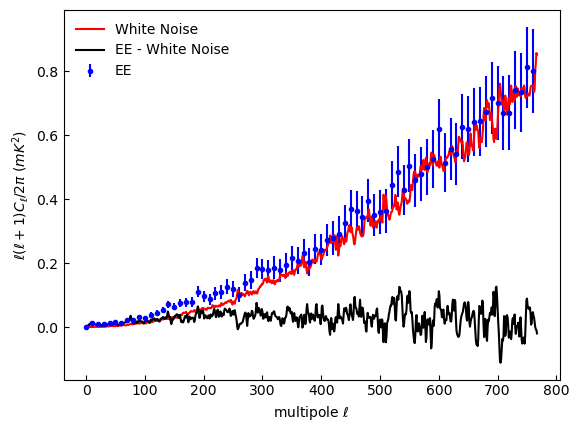

In [29]:
k = 'EE'
plt.figure()
y1 = 1000**2*l*(l+1)*psd[k]/2/np.pi
yerr = 1000**2*l*(l+1)*(psd_error + psd_error*(sigma_g)**2 + psd[k]*(sigma_g)**2)/2/np.pi #how do i add the gain error here, i cant just add it linearly and square it because the units arent the same
plt.errorbar(l[0::10], y1[0::10], yerr=yerr[0::10], fmt='b.', label='EE')
#plt.plot(l, y1, label='EE')
y2 = 1000**2*l*(l+1)*WN/2/np.pi
plt.plot(l, y2, 'r-', label = 'White Noise')
plt.plot(l, y1-y2, 'k-', label=k+' - White Noise')
#plt.xlabel('samples')
#plt.ylabel('signal (K)')
plt.legend(frameon=False)
plt.ylabel('$\ell(\ell+1)C_{\ell}/2\pi$ $(mK^2)$')
plt.xlabel('multipole $\ell$')
plt.tick_params(direction='in')
#plt.savefig('../../../../school/grad_school/research/thesis/images/EEspectrum.png')

Text(0.5, 0, 'multipole $\\ell$')

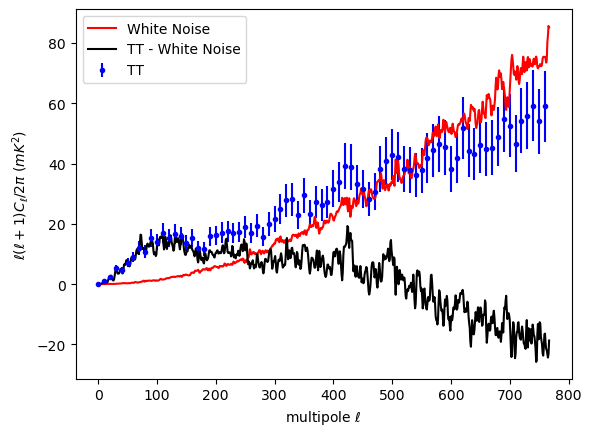

In [31]:
k = 'TT'
plt.figure()
y1 = 1000**2*l*(l+1)*psd[k]/2/np.pi
yerr = 1000**2*l*(l+1)*(psd_error + psd_error*(sigma_g)**2 + psd[k]*(sigma_g)**2)*(TNET/NET)/2/np.pi #how do i add the gain error here, i cant just add it linearly and square it because the units arent the same
plt.errorbar(l[0::10], y1[0::10], yerr=yerr[0::10], fmt='b.', label=k)
#plt.plot(l, y1, label=k)
y2 = 1000**2*l*(l+1)*WN*100/2/np.pi
plt.plot(l, y2, 'r-', label = 'White Noise')
plt.plot(l, y1-y2, 'k-', label=k+' - White Noise')
#plt.xlabel('samples')
#plt.ylabel('signal (K)')
plt.legend()
plt.ylabel('$\ell(\ell+1)C_{\ell}/2\pi$ $(mK^2)$')
plt.xlabel('multipole $\ell$')
#plt.savefig('../../../../school/grad_school/research/thesis/images/TTspectrum.png')

Text(0.5, 0, 'multipole $\\ell$')

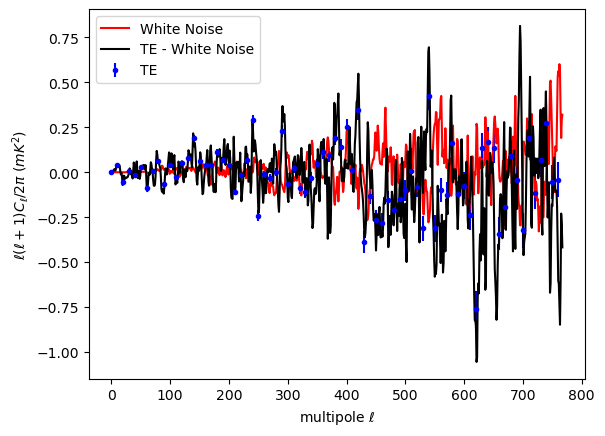

In [34]:
k = 'TE'
plt.figure()
yerr = 1000**2*l*(l+1)*(psd_error + psd_error*(sigma_g)**2 + abs(psd[k])*(sigma_g)**2)/2/np.pi #how do i add the gain error here, i cant just add it linearly and square it because the units arent the same
plt.errorbar(l[0::10], y1[0::10], yerr=yerr[0::10], fmt='b.', label=k)
#plt.plot(l, y1, label='EE')
y2 = 1000**2*l*(l+1)*2*wn_test[k]/2/np.pi
plt.plot(l, y2, 'r-', label = 'White Noise')
plt.plot(l, y1-y2, 'k-', label=k+' - White Noise')
y1 = 1000**2*l*(l+1)*psd[k]/2/np.pi
plt.legend()
plt.ylabel('$\ell(\ell+1)C_{\ell}/2\pi$ $(mK^2)$')
plt.xlabel('multipole $\ell$')
#plt.savefig('../../../../school/grad_school/research/thesis/images/TEspectrum.png')

Text(0.5, 0, 'multipole $\\ell$')

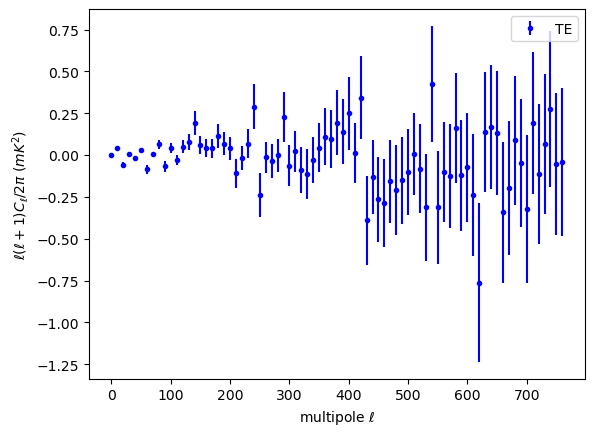

In [33]:
k = 'TE'
plt.figure()
y1 = 1000**2*l*(l+1)*psd[k]/2/np.pi
yerr = 1000**2*l*(l+1)*(psd_error + psd_error*(sigma_g)**2 + abs(psd[k])*(sigma_g)**2)*(TNET/NET)/2/np.pi #how do i add the gain error here, i cant just add it linearly and square it because the units arent the same
plt.errorbar(l[0::10], y1[0::10], yerr=yerr[0::10], fmt='b.', label=k)
#plt.plot(l, y1, label=k)
y2 = 1000**2*l*(l+1)*WN*100/2/np.pi
#plt.plot(l, y2, 'r-', label = 'White Noise')
#plt.plot(l, y1-y2, 'k-', label=k+' - White Noise')
#plt.xlabel('samples')
#plt.ylabel('signal (K)')
plt.legend()
plt.ylabel('$\ell(\ell+1)C_{\ell}/2\pi$ $(mK^2)$')
plt.xlabel('multipole $\ell$')

In [35]:
sigma_g = gerror/gain

In [36]:
NET = 1.11e-3
sampling_frequency = 33.97
gain = -1.24

In [37]:
hits[hits == 0.0] = hp.UNSEEN

In [38]:
hittotal = (hits[hits!=hp.UNSEEN].sum())
timetotal = (hits[hits!=hp.UNSEEN].sum()/sampling_frequency/3600.)

print(hittotal, timetotal)

1384000.0 11.317175285382527


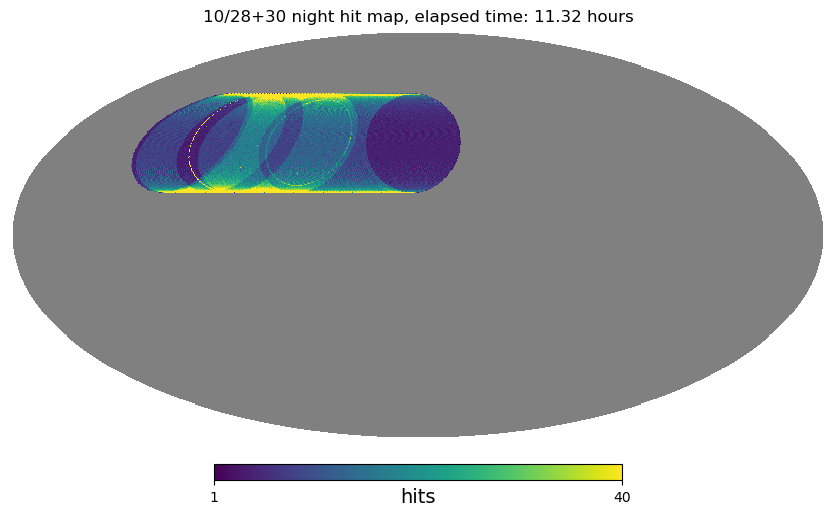

In [39]:
hp.mollview(hits, max=40, unit='hits', title='10/%s %s hit map, elapsed time: %.2f hours' % (day, periods, timetotal))
#plt.savefig('../../polaris_data/destriped/move/%s/hits.png' % folder, facecolor = 'w', transparent = False)

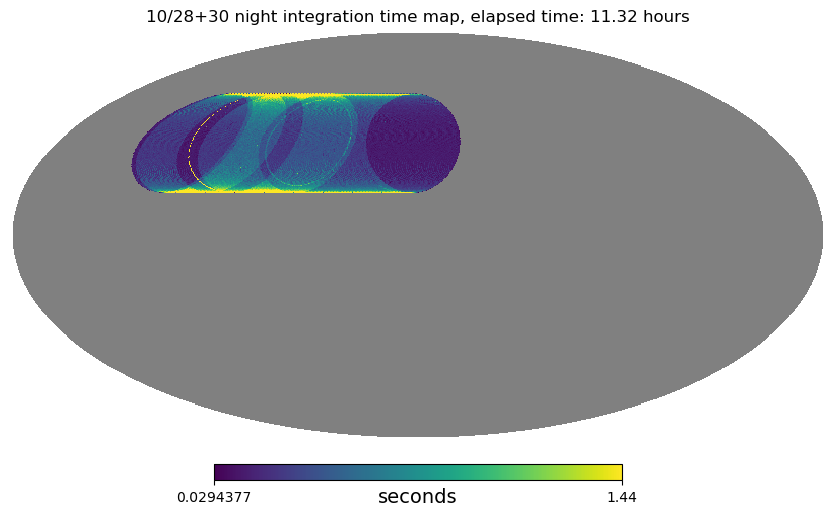

In [40]:
inttime = (hits/sampling_frequency)
inttime[inttime==inttime.min()] = hp.UNSEEN
etime = 0.0004*3600
hp.mollview(inttime, max=etime, unit='seconds', title='10/%s %s integration time map, elapsed time: %.2f hours' % (day, periods, timetotal))
#plt.savefig('../../polaris_data/destriped/move/%s/inttime.png' % folder, facecolor = 'w', transparent = False)

In [41]:
sensitivity = NET/np.sqrt(hits/sampling_frequency)

/var/folders/n8/mc27w99j19q1kx20z133q0w40000gp/T/ipykernel_33773/926265821.py:1: RuntimeWarning: invalid value encountered in sqrt
  sensitivity = NET/np.sqrt(hits/sampling_frequency)


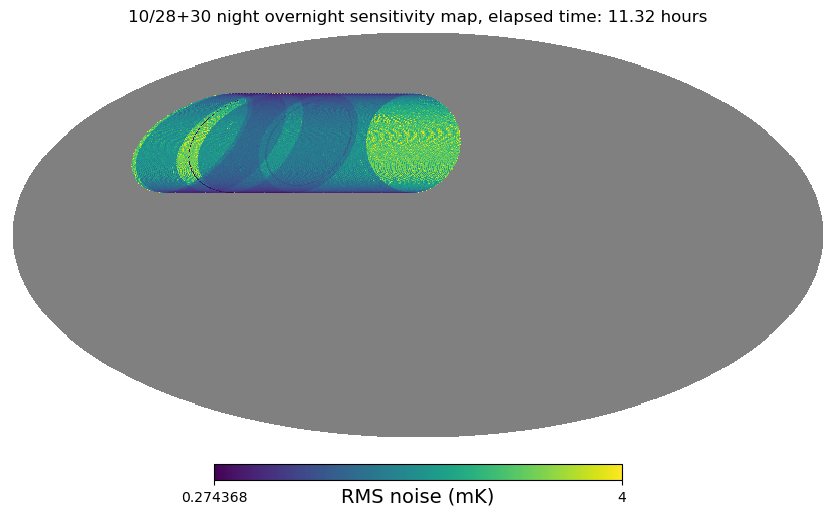

In [43]:
hp.mollview(1000*sensitivity, max = 4, unit='RMS noise (mK)', title='10/%s %s overnight sensitivity map, elapsed time: %.2f hours' % (day, periods, timetotal))
plt.savefig('../../polaris_data/destriped/move/%s/sensitivity.png' % folder, facecolor = 'w', transparent = False)

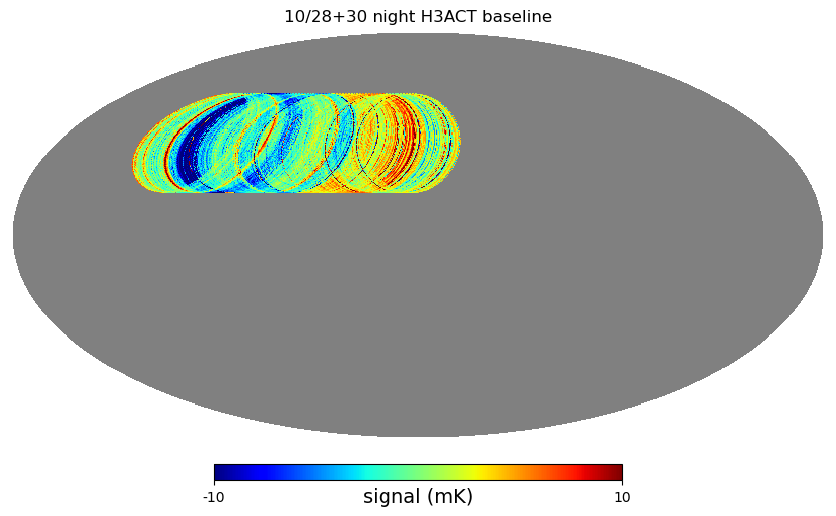

In [44]:
val = 10
baseline = baselineT*1e3
baseline[baseline==baseline.min()] = hp.UNSEEN
hp.mollview(baseline, min = -val, max = val, unit='signal (mK)', cmap ='jet', title='10/%s %s H3ACT baseline' % (day, periods))
plt.savefig('../../polaris_data/destriped/move/%s/baseline.png' % folder, facecolor = 'w', transparent = False)

<IPython.core.display.Javascript object>


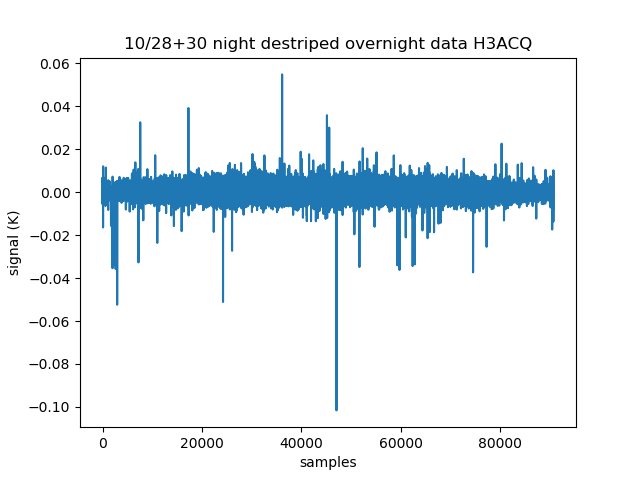

In [24]:
plt.figure()
var = 'Q'
plt.plot(Q[U!=hp.UNSEEN])
plt.xlabel('samples')
plt.ylabel('signal (K)')
plt.title('10/%s %s destriped overnight data H3AC%s' % (day, periods, var))
#plt.savefig('../../polaris_data/destriped/move/%s/destriped_signal%s_TOI.png' % (folder, var), facecolor = 'w', transparent = False)

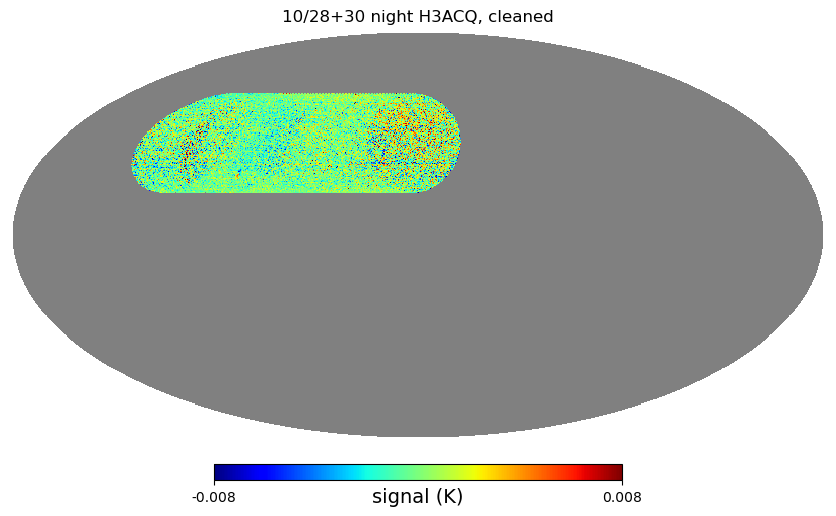

In [46]:
val = 0.008
hp.mollview(Q, min = -val, max = val, unit='signal (K)', cmap ='jet', title='10/%s %s H3ACQ, cleaned' % (day, periods))

#plt.savefig('../../polaris_data/destriped/move/%s/signalQ.png' % folder, facecolor = 'w', transparent = False)
#plt.show()

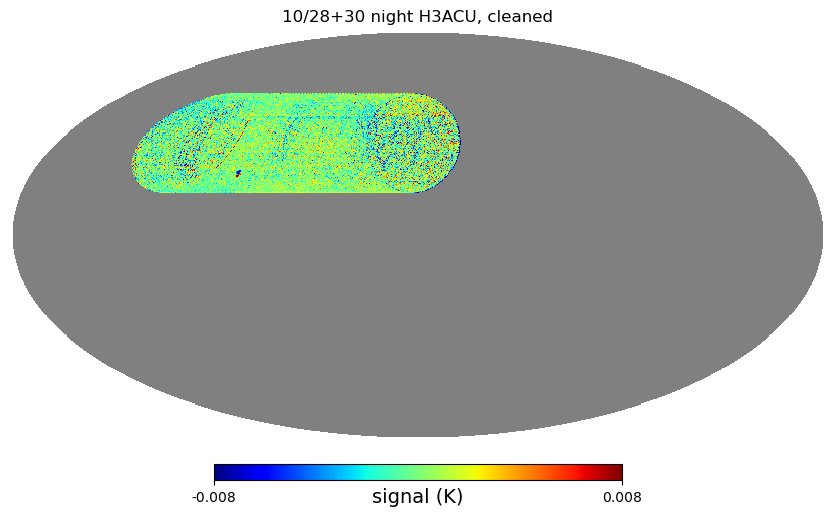

In [48]:
val = 0.008
hp.mollview(U, min = -val, max = val, unit='signal (K)', cmap ='jet', title='10/%s %s H3ACU, cleaned' % (day, periods))
#plt.savefig('../../polaris_data/destriped/move/%s/signalU.png' % folder, facecolor = 'w', transparent = False)
#plt.show()

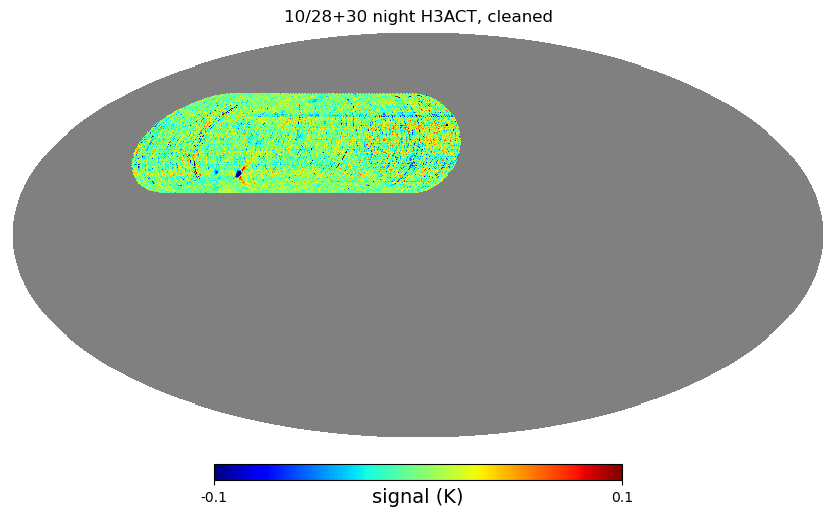

In [49]:
val = 0.1
hp.mollview(T, min = -val, max = val, unit='signal (K)', cmap ='jet', title='10/%s %s H3ACT, cleaned' % (day, periods))
#plt.savefig('../../polaris_data/destriped/move/%s/signalT.png' % folder, facecolor = 'w', transparent = False)
#plt.show()

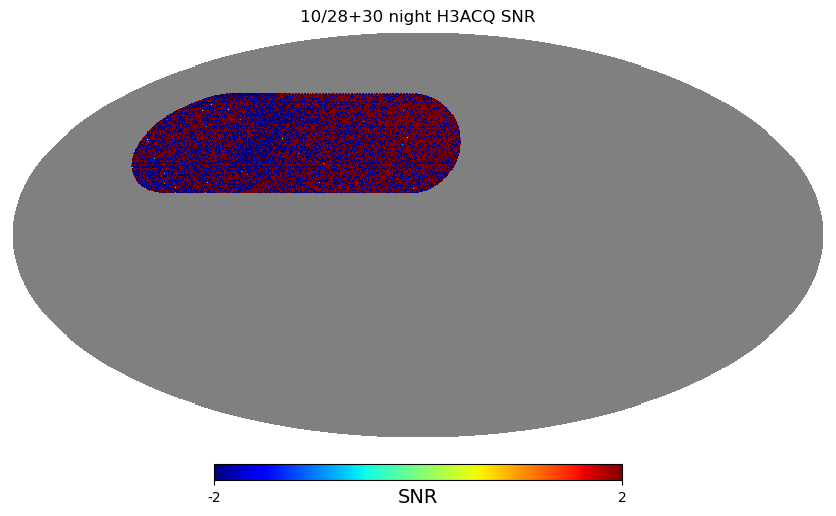

In [50]:
val = 0.002/1e-3
hp.mollview(Q/sensitivity/1e-3, min = -val, max = val, unit='SNR', cmap ='jet', title='10/%s %s H3ACQ SNR' % (day, periods))
#plt.savefig('../../polaris_data/destriped/move/%s/SNRQ.png' % folder, facecolor = 'w', transparent = False)
#plt.show()

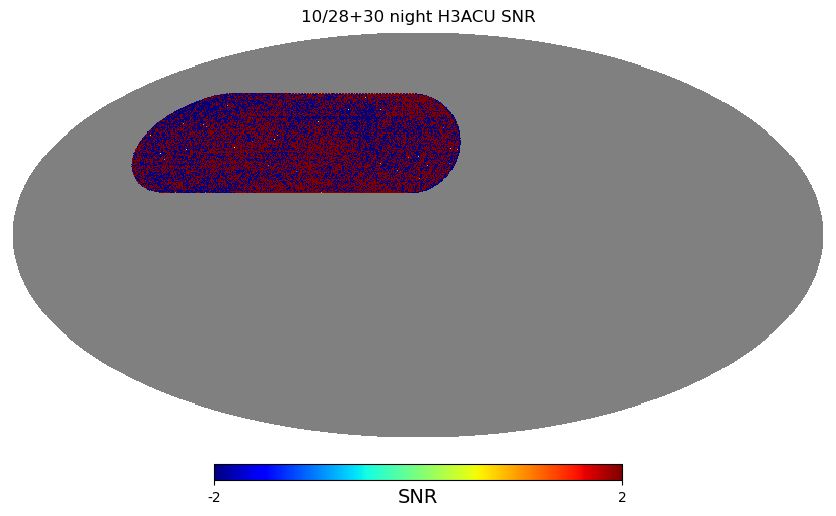

In [51]:
val = 0.002/1e-3
hp.mollview(U/sensitivity/1e-3, min = -val, max = val, unit='SNR', cmap ='jet', title='10/%s %s H3ACU SNR' % (day, periods))
#plt.savefig('../../polaris_data/destriped/move/%s/SNRU.png' % folder, facecolor = 'w', transparent = False)
#plt.show()

In [53]:
f = '../../polaris_data/level1/sedgwick/2020/20201028/old/H3AC_night_only_az_mean_removed.h5'
data=h5py.File(f)['data']

In [54]:
Tdata = data['TEMP']
Qdata = data['Q']
Udata = data['U']
ra = np.degrees(data['PHI'])
dec = np.degrees(np.pi/2. - data['THETA'])

phi = data['PHI']
theta = data['THETA']


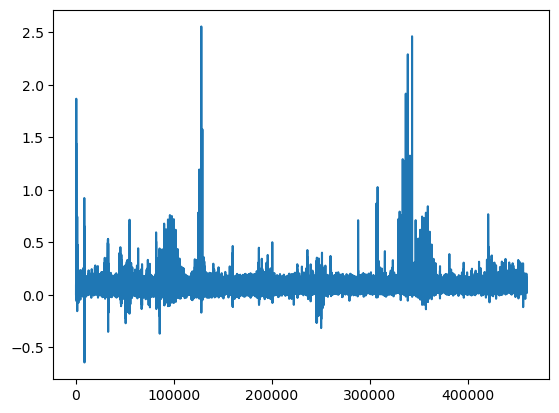

In [56]:
plt.figure()
plt.plot(Tdata)

In [57]:
RA, DEC, sig = plotnow_azelsig(Tdata, ra, dec, 'ch8', 'T', 0.5, minmax=None, radec=True, return_map=True)

[20.71940043 20.74437335 20.77294397 ... 44.55545497 44.61074547
 44.67085494]


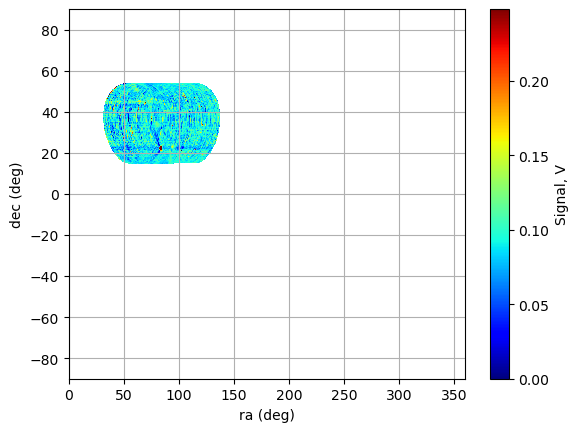

In [58]:
plt.figure()
plt.pcolormesh(RA, DEC, sig, cmap='jet')
plt.colorbar(label = 'Signal, V')
vmin = 0.0
vmax = 0.2*1.24
plt.clim(vmin,vmax)
radec=True
if radec == False:
    plt.axis([AZ.min(), AZ.max(), EL.min(), EL.max()])
    plt.ylabel('elevation (deg)')
    plt.xlabel('azimuth (deg)')
else:
    plt.axis([0., 360., -90, 90.])
    plt.xlabel('ra (deg)')
    plt.ylabel('dec (deg)')
#plt.title('%s %s removed binned az mean' % (chan, var))
plt.grid()
plt.show()

In [59]:
ramin = 82.
ramax = 86.
decmin = 21.
decmax = 23.5

data_crab = Tdata[(ra>ramin) & (ra<ramax) & (dec>decmin) & (dec<decmax)][:2992]
ra_crab = ra[(ra>ramin) & (ra<ramax) & (dec>decmin) & (dec<decmax)][:2992]
dec_crab = dec[(ra>ramin) & (ra<ramax) & (dec>decmin) & (dec<decmax)][:2992]

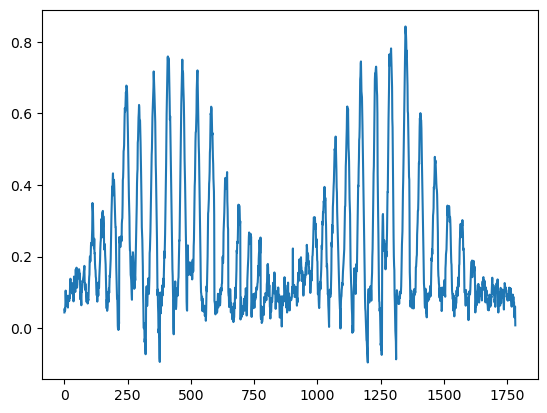

In [60]:
plt.figure()
plt.plot(data_crab)

In [61]:
Tmax = data_crab.max()
ramax = ra_crab[data_crab==Tmax]
decmax = dec_crab[data_crab==Tmax]
print(ramax, decmax)

[83.63748037] [22.56463292]


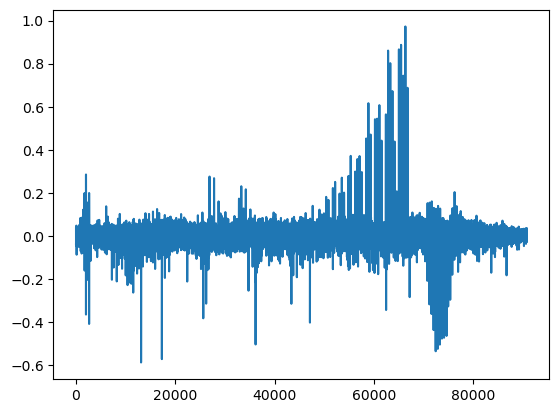

In [62]:
plt.figure()
plt.plot(T[T != hp.UNSEEN])

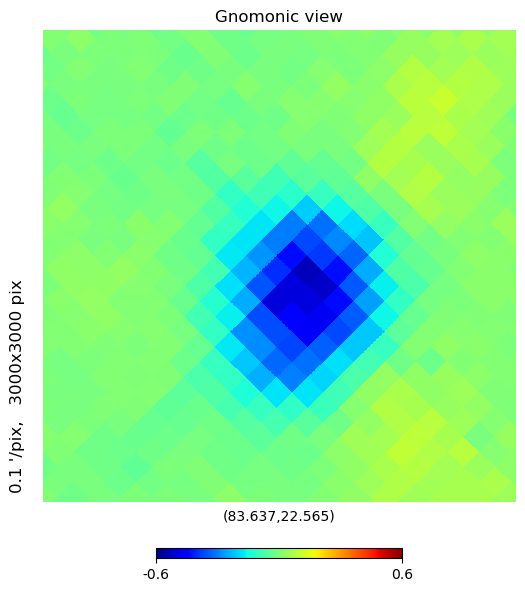

In [63]:
res = 0.1
xsize = 300/res
gmap = hp.gnomview(T, min=-0.6, max=0.6, reso=res, xsize=xsize, rot=(ramax, decmax, 0.), return_projected_map=True, cmap='jet')
#plt.savefig('../../polaris_software/data_acquisition/plots/acq_tel_plots/sedgwick/2020/gnomview_tauA_20201029.png', facecolor = 'w', transparent = False)